1. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Add
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import random

2023-02-07 08:20:21.169261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# check GPU status
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-02-07 08:20:22.600741: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-07 08:20:22.702211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:57:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-07 08:20:22.702240: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-07 08:20:22.706022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-07 08:20:22.706084: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-07 08:20:22.707114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [3]:
# helpers
def count_files(root_path):
    print('count files in:' + root_path)
    assert os.path.exists(root_path)
    total_files = 0
    item_list = os.listdir(root_path)
    if len(item_list) == 0:
        return 0
    for item in item_list:
        next_path = os.path.join(root_path, item)
        if os.path.isfile(next_path):
            total_files += 1
        else:
            total_files += count_files(next_path)

    return total_files

def random_noise(image, noise_num):
    '''
    Add random noise（实际上就是随机在图像上将像素点的灰度值变为255即白色）
    param image: 需要加噪的图片
    param noise_num: 添加的噪音点数目
    return: img_noise
    '''
    # 参数image：，noise_num：
    img_noise = image
    # cv2.imshow("src", img)
    rows, cols, chn = img_noise.shape
    # 加噪声
    for i in range(noise_num):
        x = np.random.randint(0, rows)  # 随机生成指定范围的整数
        y = np.random.randint(0, cols)
        img_noise[x, y, :] = 255
    return img_noise

def sp_noise(noise_img, proportion):
    """
    添加椒盐噪声
    proportion的值表示加入噪声的量，可根据需要自行调整
    return: img_noise
    """
    height, width = noise_img.shape[0], noise_img.shape[1]  # 获取高度宽度像素值
    num = int(height * width * proportion)  # 一个准备加入多少噪声小点
    for i in range(num):
        w = random.randint(0, width - 1)
        h = random.randint(0, height - 1)
        if random.randint(0, 1) == 0:
            noise_img[h, w] = 0
        else:
            noise_img[h, w] = 255
    return noise_img


def gaussian_noise(img, mean, sigma):
    """
    此函数用将产生的高斯噪声加到图片上
    传入:
        img   :  原图
        mean  :  均值
        sigma :  标准差
    返回:
        gaussian_out : 噪声处理后的图片
    """
    # 将图片灰度标准化
    img = img / 255
    # 产生高斯 noise
    noise = np.random.normal(mean, sigma, img.shape)
    # 将噪声和图片叠加
    gaussian_out = img + noise
    # 将超过 1 的置 1，低于 0 的置 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    # 将图片灰度范围的恢复为 0-255
    gaussian_out = np.uint8(gaussian_out * 255)
    # 将噪声范围搞为 0-255
    # noise = np.uint8(noise*255)
    return gaussian_out  # 这里也会返回噪声，注意返回值

def compare_show_2_img_arrays(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10
    
    print('dirty len: ' + str(len(array1)))
    print('prediction len:' + str(len(array2)))

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(48, 48))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(48, 48))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
    
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

2. Handling inputs

In [4]:
# Some important directories
DATA_DIR = os.path.join("/", "root", "autodl-tmp", "data")
RANDOM_NOISE_DATA_DIR = os.path.join("/", "root", "autodl-tmp", "random_noise_data")
GAUSSIAN_NOISE_DATA_DIR = os.path.join("/root/autodl-tmp/gaussian_noise_data")
SALT_PEPPER_NOISE_DATA_DIR = os.path.join("/root/autodl-tmp/salt_pepper_noise_data")


TEST_DATA_DIR = os.path.join(DATA_DIR, "test")
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train")

### random noise dataset ###
TEST_RANDOM_NOISE_DATA_DIR = os.path.join(RANDOM_NOISE_DATA_DIR, "test")
TRAIN_RANDOM_NOISE_DATA_DIR = os.path.join(RANDOM_NOISE_DATA_DIR, "train")

BATCH_SIZE = 16
VALIDATION_RATE = 0.2
IMAGE_SIZE = 48

# count train data number
NUM_TRAIN_DATA = count_files(TRAIN_DATA_DIR)

# load the dataset
# Generate batches of tensor image data with real-time data augmentation
# rescale to convert the pixels in range [0,255] to range [0,1]. This process is Normalizing.
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_RATE
)

# Validation data, No augmentation is performed, except normalization
dategen_valid = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VALIDATION_RATE
)

# rescale to convert the pixels in range [0,255] to range [0,1]. This process is Normalizing.
datagen_test = ImageDataGenerator(
    rescale=1. / 255,
)


count files in:/root/autodl-tmp/data/train
count files in:/root/autodl-tmp/data/train/angry
count files in:/root/autodl-tmp/data/train/disgust
count files in:/root/autodl-tmp/data/train/fear
count files in:/root/autodl-tmp/data/train/happy
count files in:/root/autodl-tmp/data/train/neutral
count files in:/root/autodl-tmp/data/train/sad
count files in:/root/autodl-tmp/data/train/surprise


3. Create data generators

In [5]:
# grayscale 1 channel inputs

#### original ###
train_img_generator = datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_img_generator = dategen_valid.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_img_generator = datagen_test.flow_from_directory(
    directory=TEST_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

class_indices = train_img_generator.class_indices
num_classes = len(class_indices)
##################

#### random noise ###
train_random_noise_img_generator = datagen.flow_from_directory(
    directory=TRAIN_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_random_noise_img_generator = dategen_valid.flow_from_directory(
    directory=TRAIN_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_random_noise_img_generator = datagen_test.flow_from_directory(
    directory=TEST_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


4. Models

In [6]:
### Implement with VGG16 Model ###
# https://github.com/gayathri1462/Face-Emotion-Recognition
# can only use 1-channel images
def build_VGG16_model():
    model=Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes,activation='softmax'))

    model.summary()

    return model


### Implement denoising autoencoder network ###
class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.Encoder = tf.keras.models.Sequential([
            Conv2D(16, (3,3), kernel_initializer='normal', padding='same', activation='relu'),
            MaxPooling2D((2,2)),
            Conv2D(8, (3,3), kernel_initializer='normal', padding='same', activation='relu'),
            MaxPooling2D((2,2))
        ])
        self.Decoder = tf.keras.models.Sequential([
            UpSampling2D((2,2)),
            Conv2D(8, (3,3), kernel_initializer='normal', padding='same', activation='relu'),
            UpSampling2D((2,2)),
            Conv2D(16, (3,3), kernel_initializer='normal', padding='same', activation='relu'),
            Conv2D(1, (3,3), kernel_initializer='normal', padding='same', activation='sigmoid')
        ])

    def call(self, input_features, training = None):
        code = self.Encoder(input_features)
        reconstructed = self.Decoder(code)
        return reconstructed
    

# vgg16 will be trained by original images, and then merge with auto encoder.
vgg16_model = build_VGG16_model()

# test in handling random noise
denoising_auto_encoder_model = DenoisingAutoencoder()

2023-02-07 08:20:25.489662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 08:20:25.494419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:57:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-07 08:20:25.495076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-07 08:20:25.495133: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-07 08:20:26.012707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interco

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

5. prepare the autoencoder data

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
dirty len: 16
prediction len:16


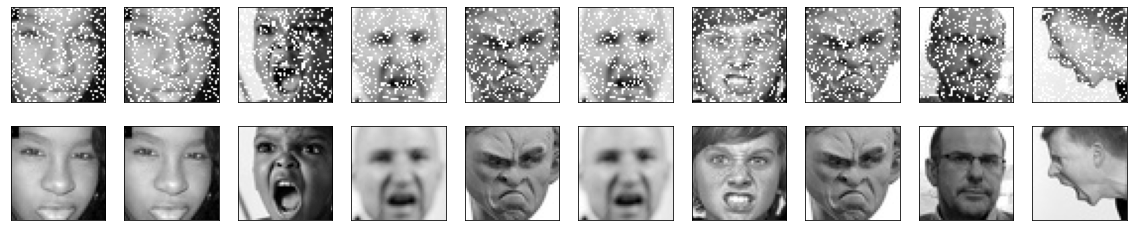

count files in:/root/autodl-tmp/data/train
count files in:/root/autodl-tmp/data/train/angry
count files in:/root/autodl-tmp/data/train/disgust
count files in:/root/autodl-tmp/data/train/fear
count files in:/root/autodl-tmp/data/train/happy
count files in:/root/autodl-tmp/data/train/neutral
count files in:/root/autodl-tmp/data/train/sad
count files in:/root/autodl-tmp/data/train/surprise
get 28709 image files for autoencoder training


In [7]:
# test in handling random noise

# prepare the data for training encoders
### dataset without noise ###

# use the generator without prevent augmentations in the input images, but only normalization.
dategen_train_autoencoder = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VALIDATION_RATE
)

# rescale to convert the pixels in range [0,255] to range [0,1]. This process is Normalizing.
datagen_test_autoencoder = ImageDataGenerator(
    rescale=1. / 255,
)

# need to set shuffle to false to map noisy to clean one
clean_encoder_train_data = dategen_train_autoencoder.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset="training",
    shuffle=False
)

clean_encoder_validation_data = dategen_train_autoencoder.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset="validation",
    shuffle=False
)

clean_encoder_test_data = datagen_test_autoencoder.flow_from_directory(
    directory=TEST_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

##########

#### random noise ###
random_noise_encoder_train_data = dategen_train_autoencoder.flow_from_directory(
    directory=TRAIN_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset="training",
    shuffle=False
)

random_noise_encoder_validation_data = dategen_train_autoencoder.flow_from_directory(
    directory=TRAIN_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset="validation",
    shuffle=False
)

random_noise_encoder_test_data = datagen_test_autoencoder.flow_from_directory(
    directory=TEST_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

##########

# see input data
compare_show_2_img_arrays(random_noise_encoder_train_data.next(), clean_encoder_train_data.next())

# count num of all data files
num_autoencoder_train_data = count_files(TRAIN_DATA_DIR)
print('get ' + str(num_autoencoder_train_data) + ' image files for autoencoder training')


6. Train auto-encoder

In [ ]:

# x: dirty-data, y: clean-data
autoencoder_train_dataset = zip(random_noise_encoder_train_data, clean_encoder_train_data)
autoencoder_validation_dataset = zip(random_noise_encoder_validation_data, clean_encoder_validation_data)
autoencoder_test_dataset = zip(random_noise_encoder_test_data, clean_encoder_test_data)

# some helpers
## Early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience = 20, mode = 'min', restore_best_weights=True)

## Reduce learning rate when metric has stopped improving.
lrd_callback = ReduceLROnPlateau(verbose = 1, factor = 0.50, min_lr = 1e-10)

# compile and run the model
denoising_auto_encoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',  tf.keras.metrics.AUC(name='auc')])
denoising_auto_encoder_model.fit(
    autoencoder_train_dataset,
    epochs=100,
    verbose = 1,
    callbacks=[early_stop_callback, lrd_callback],
    steps_per_epoch=num_autoencoder_train_data * (1 - VALIDATION_RATE) // BATCH_SIZE,
    shuffle=True,
    validation_data=autoencoder_validation_dataset,
    validation_steps=num_autoencoder_train_data * VALIDATION_RATE // BATCH_SIZE
)


2023-02-07 08:20:30.213637: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-07 08:20:30.944001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2023-02-07 08:20:31.819440: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-07 08:20:32.458805: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-07 08:20:32.674938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-07 08:20:32.677360: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz


Epoch 1/100
1435/1435 [==============================] - 25s 17ms/step - loss: 0.5699 - accuracy: 0.0144 - auc: 0.9492 - val_loss: 0.5618 - val_accuracy: 0.0140 - val_auc: 0.9734
Epoch 2/100
1435/1435 [==============================] - 24s 17ms/step - loss: 0.5586 - accuracy: 0.0147 - auc: 0.9776 - val_loss: 0.5592 - val_accuracy: 0.0140 - val_auc: 0.9789
Epoch 3/100
1435/1435 [==============================] - 24s 16ms/step - loss: 0.5570 - accuracy: 0.0147 - auc: 0.9810 - val_loss: 0.5580 - val_accuracy: 0.0140 - val_auc: 0.9811
Epoch 4/100
1435/1435 [==============================] - 24s 17ms/step - loss: 0.5561 - accuracy: 0.0147 - auc: 0.9826 - val_loss: 0.5571 - val_accuracy: 0.0140 - val_auc: 0.9827
Epoch 5/100
1435/1435 [==============================] - 24s 17ms/step - loss: 0.5556 - accuracy: 0.0148 - auc: 0.9835 - val_loss: 0.5566 - val_accuracy: 0.0140 - val_auc: 0.9834
Epoch 6/100
1435/1435 [==============================] - 24s 17ms/step - loss: 0.5553 - accuracy: 0.0148 

6. see effect of auto-encoders

Found 7178 images belonging to 7 classes.
dirty len: 16
prediction len:16


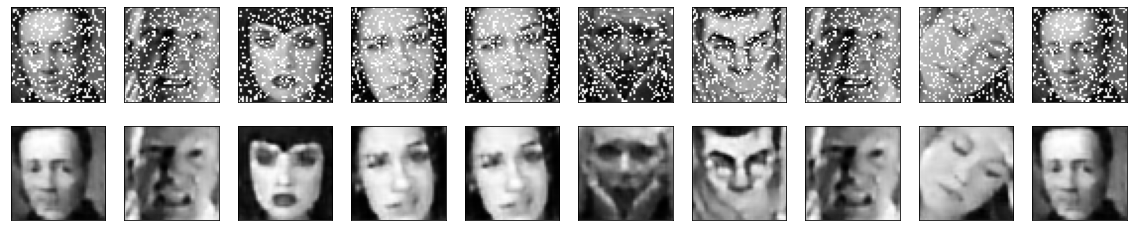

In [11]:
# dirty_test_data = tf.keras.preprocessing.image_dataset_from_directory(
#   TEST_RANDOM_NOISE_DATA_DIR,
#   color_mode='grayscale',
#   image_size=(IMAGE_SIZE, IMAGE_SIZE), 
#   label_mode=None,
# )

dirty_test_data = datagen_test.flow_from_directory(
    directory=TEST_RANDOM_NOISE_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None
)

feed_data = dirty_test_data.next()
predictions = denoising_auto_encoder_model.predict(feed_data)

# see autoencoder result
compare_show_2_img_arrays(feed_data, predictions)
